---
title: py4DSTEM Parallax Masks Notebook
authors: [Georgios Varnavides]
date: 2024/07/22
---

### Imports

In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import py4DSTEM

import ipywidgets
from IPython.display import display

style = {'description_width': 'initial'}

### Load Data

In [2]:
file_path = 'data/'
file_data_01 = file_path + 'parallax_apoferritin_simulation_100eA2_01.h5'
file_data_02 = file_path + 'parallax_apoferritin_simulation_100eA2_02.h5'

dataset_01 = py4DSTEM.read(file_data_01)
dataset_02 = py4DSTEM.read(file_data_02)
dataset = py4DSTEM.DataCube(np.hstack((dataset_01.data,dataset_02.data)),calibration=dataset_01.calibration)
dataset

DataCube( A 4-dimensional array of shape (24, 48, 128, 128) called 'datacube',
          with dimensions:

              Rx = [0.0,10.666666666666666,21.333333333333332,...] A
              Ry = [0.0,10.666666666666666,21.333333333333332,...] A
              Qx = [0.0,0.1538085070134974,0.3076170140269948,...] mrad
              Qy = [0.0,0.1538085070134974,0.3076170140269948,...] mrad
)

### Basic Visualizations

In [3]:
mean_diffraction_pattern = dataset.get_dp_mean().data
mean_diffraction_pattern /= mean_diffraction_pattern.max()
bright_field_mask = mean_diffraction_pattern > 0.5
bright_field_mask_indices_vertical, bright_field_mask_indices_horizontal = np.where(bright_field_mask)

reciprocal_sampling = dataset.calibration.get_Q_pixel_size()
reciprocal_units = dataset.calibration.get_Q_pixel_units()
reciprocal_kwargs = {"pixelsize":reciprocal_sampling,"pixelunits":reciprocal_units,"scalebar":{"length":5},"ticks":False}

virtual_bright_field_images = dataset[:,:,bright_field_mask].transpose(2,0,1)
gridscan_sampling = dataset.calibration.get_R_pixel_size()
real_kwargs = {"pixelsize":gridscan_sampling/10,"pixelunits":"nm","scalebar":{"color":"black","length":10},"ticks":False}

In [4]:
def return_axial_image_and_mask(axial_r):
    """ """
    axial_bf_indices = np.unravel_index(
        np.argwhere(
            np.linalg.norm(
                np.argwhere(np.ones_like(bright_field_mask)) - np.array(bright_field_mask.shape)[None]/2,
                axis=1
            ) < axial_r
        ),
        bright_field_mask.shape
    )     
    
    axial_bf_image = dataset[:,:,axial_bf_indices[0],axial_bf_indices[1]].sum((-2,-1))
    bright_field_mask_rgb = np.zeros(bright_field_mask.shape+(3,))
    
    # cyan
    bright_field_mask_rgb[bright_field_mask,1:] =1 
    
    # magenta
    bright_field_mask_rgb[axial_bf_indices[0],axial_bf_indices[1],0]=1
    bright_field_mask_rgb[axial_bf_indices[0],axial_bf_indices[1],1]=0
    bright_field_mask_rgb[axial_bf_indices[0],axial_bf_indices[1],2]=1

    return axial_bf_image, bright_field_mask_rgb


def update_axial_image_and_mask(change):
    axial_r = change["new"]
    axial_bf_image, bright_field_mask_rgb = return_axial_image_and_mask(axial_r)

    axial_artists[0].set_data(bright_field_mask_rgb)
    
    _axial_bf_image, _vmin, _vmax = py4DSTEM.visualize.return_scaled_histogram_ordering(axial_bf_image)
    axial_artists[1].set_data(_axial_bf_image)
    axial_artists[1].set_clim(vmin=_vmin, vmax=_vmax)
    
    fig_axial.canvas.draw_idle()
    return None

axial_r_slider = ipywidgets.IntSlider(min=1, max=26, step=1, style=style, description="axial virtual BF radius")
axial_r_slider.observe(update_axial_image_and_mask,names='value')

In [5]:
with plt.ioff():
    dpi = 72
    fig_axial = plt.figure(figsize=(675/dpi, 360/dpi), dpi=dpi)

gs = GridSpec(2, 2, wspace=0.05)
ax_bf_disk = fig_axial.add_subplot(gs[:, 0])
ax_axial = fig_axial.add_subplot(gs[0, 1])
ax_incoherent = fig_axial.add_subplot(gs[1, 1])

axial_bf_image, bright_field_mask_rgb = return_axial_image_and_mask(axial_r=1)
py4DSTEM.show(
    bright_field_mask_rgb,
    figax=(fig_axial,ax_bf_disk),
    **reciprocal_kwargs,
    title="bright field disk mask",
)

py4DSTEM.show(
    axial_bf_image,
    figax=(fig_axial,ax_axial),
    **real_kwargs,
    cmap='Greys',
    title="virtual (axial) bright field image",
    bordercolor="magenta",
    borderwidth=2,
)

py4DSTEM.show(
    virtual_bright_field_images.sum(0),
    figax=(fig_axial,ax_incoherent),
    **real_kwargs,
    cmap='Greys',
    title="incoherent bright field image",
    bordercolor="cyan",
    borderwidth=2,
)

gs.tight_layout(fig_axial)
axial_artists = [ax_bf_disk.get_images()[0],ax_axial.get_images()[0]]

fig_axial.canvas.resizable = False
fig_axial.canvas.header_visible = False
fig_axial.canvas.footer_visible = False
fig_axial.canvas.toolbar_visible = True
fig_axial.canvas.layout.width = '675px'
fig_axial.canvas.layout.height = '390px'
fig_axial.canvas.toolbar_position = 'bottom'

In [6]:
#| label: app:py4dstem_parallax_vbfs

display(
    ipywidgets.VBox(
        [
            axial_r_slider,
            fig_axial.canvas
        ],
        layout=ipywidgets.Layout(align_items='center',width='675px'))
)

### Iterative Alignment Bins

In [7]:
def return_bf_bins(bf_mask, bin_value, shift=0):
    """ """
    _xy_inds = np.argwhere(bf_mask)
    _xy_center = (_xy_inds - np.mean(_xy_inds, axis=0)).astype("float")
    _xy_inds_binned = np.round(_xy_center / bin_value + shift).astype("int")
    _xy_vals_binned = np.unique(_xy_inds_binned, axis=0)
    _inds_order = np.argsort(np.sum(_xy_vals_binned**2, axis=1))
    
    masks = np.zeros((_inds_order.shape[0],)+bf_mask.shape)
    for ind, bin_ind in enumerate(_inds_order):
        sub = np.logical_and(
            _xy_inds_binned[:, 0] == _xy_vals_binned[bin_ind, 0],
            _xy_inds_binned[:, 1] == _xy_vals_binned[bin_ind, 1],
        )
        indexing_i, indexing_j = _xy_inds[sub].T
        masks[ind,indexing_i,indexing_j]=1
    return masks

def return_bf_bins_rgb(bf_mask, bin_value, shift=0):
    """ """
    bins=return_bf_bins(bf_mask, bin_value, shift=shift)
    n = bins.shape[0]
    hue_angles = np.linspace(0.0, 2.0 * np.pi, n, endpoint=False)
    complex_arr = np.tensordot(np.exp(1j*hue_angles),bins,axes=1)
    return py4DSTEM.visualize.Complex2RGB(complex_arr)

bins_32 = return_bf_bins_rgb(bright_field_mask,32)
bins_16 = return_bf_bins_rgb(bright_field_mask,16)
bins_8 = return_bf_bins_rgb(bright_field_mask,8)
bins_4 = return_bf_bins_rgb(bright_field_mask,4)
bins_2 = return_bf_bins_rgb(bright_field_mask,2)
bins_1 = return_bf_bins_rgb(bright_field_mask,1)

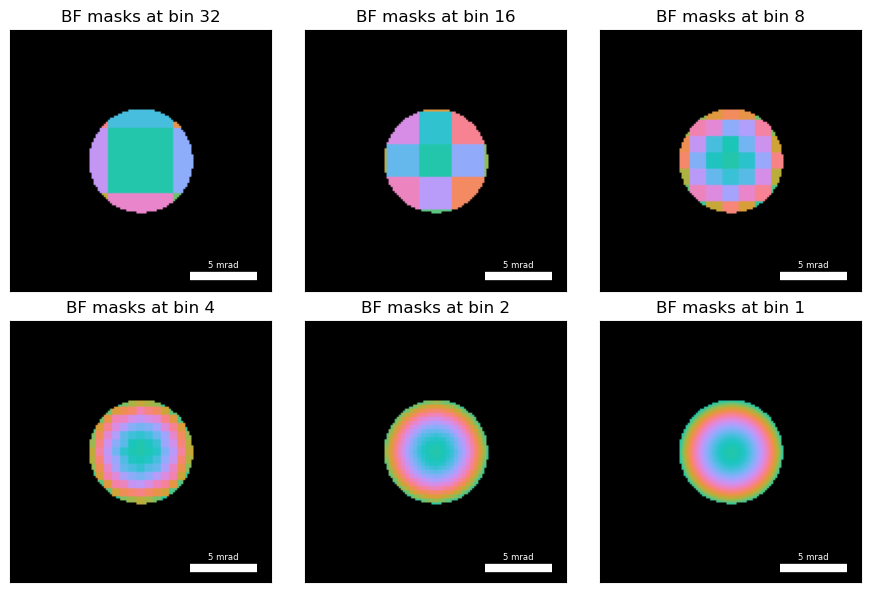

In [8]:
#| label: app:py4dstem_parallax_masks
with plt.ioff():
    py4DSTEM.show(
        [
            [bins_32, bins_16, bins_8],
            [bins_4, bins_2, bins_1]
        ],
        axsize=(3,3),
        **reciprocal_kwargs,
        title=[f"BF masks at bin {it}" for it in [32,16,8,4,2,1]]
    )
    fig_masks = plt.gcf()
fig_masks